In [2]:
from tinyphysics import TinyPhysicsModel, TinyPhysicsSimulator, CONTROL_START_IDX
from controllers import pid, pidf
from matplotlib import pyplot as plt
import seaborn as sns
from pathlib import Path

import pandas as pd
import numpy as np
from scipy import signal

ACC_G = 9.81

sns.set_theme()


/home/risa/Documents/MachineLearning/3.CommaAi/controls_challenge/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def linear_lsq(x, y, lag):
    length = len(x)
    alpha = np.sum((y[lag:] - y[lag:].mean()) * (x[:100-lag] - x[:100-lag].mean())) / (np.sum((x[:100-lag] - x[:100-lag].mean()) ** 2) + 1e-8)
    beta = y[lag:].mean() - alpha * x[:100-lag].mean()

    ssr = np.sum((alpha * x[:100-lag] + beta - y[lag:])**2)
    sst = np.sum((y[lag:] - y[lag:].mean())**2) + 1e-8
    r2 = 1 - ssr / sst

    return alpha, beta, r2

In [4]:
lag_vals = []
r2s = []
fits = []
files = []

data_dir = Path('./data/')
for f in data_dir.iterdir():
    files.append(f)
    df = pd.read_csv(str(f))
    t = df["t"].to_numpy()[:100]
    vEgo = df["vEgo"].to_numpy()[:100]
    aEgo = df["aEgo"].to_numpy()[:100]
    roll_la = np.sin(df["roll"].to_numpy()[:100]) * ACC_G
    target_la = df["targetLateralAcceleration"].to_numpy()[:100]
    steerCommands = -df["steerCommand"].to_numpy()[:100]
    steer_la = target_la - roll_la

    corr = signal.correlate(steer_la - steer_la.mean(), steerCommands - steerCommands.mean())
    lags = signal.correlation_lags(100, 100)
    lag = np.clip(lags[np.argmax(corr)], 0, 90)

    test_fits = [linear_lsq(steerCommands, steer_la, x) for x in range(lag, lag + 10)]
    lag_correction = np.argmax([x[2] for x in test_fits])
    lag += lag_correction
    
    lag_vals.append(lag)
    fits.append(np.array(test_fits[lag_correction][:2]))
    r2s.append(test_fits[lag_correction][2])
    # print(f'alpha: {alpha}\nbeta: {beta}\nR^2: {r2}')

    # plt.plot(steerCommands[:100-lag], steer_la[lag:], '.')
    # x = np.linspace(-0.5, 0.5, 2)
    # plt.plot(x, alpha * x + beta)

    # plt.xlabel('steer command')
    # plt.ylabel('lataccel')
    # # plt.xlim(-2, 2)
    # # plt.ylim(-3, 3)
    # plt.show()

In [10]:
alpha = np.array(fits)[:, 0]
alpha = alpha[0 < alpha]
alpha = alpha[alpha < 3]
mu_alpha = alpha.mean()

beta = np.array(fits)[:, 1]
beta = beta[-1 < beta]
beta = beta[beta < 1]
mu_beta = beta.mean()

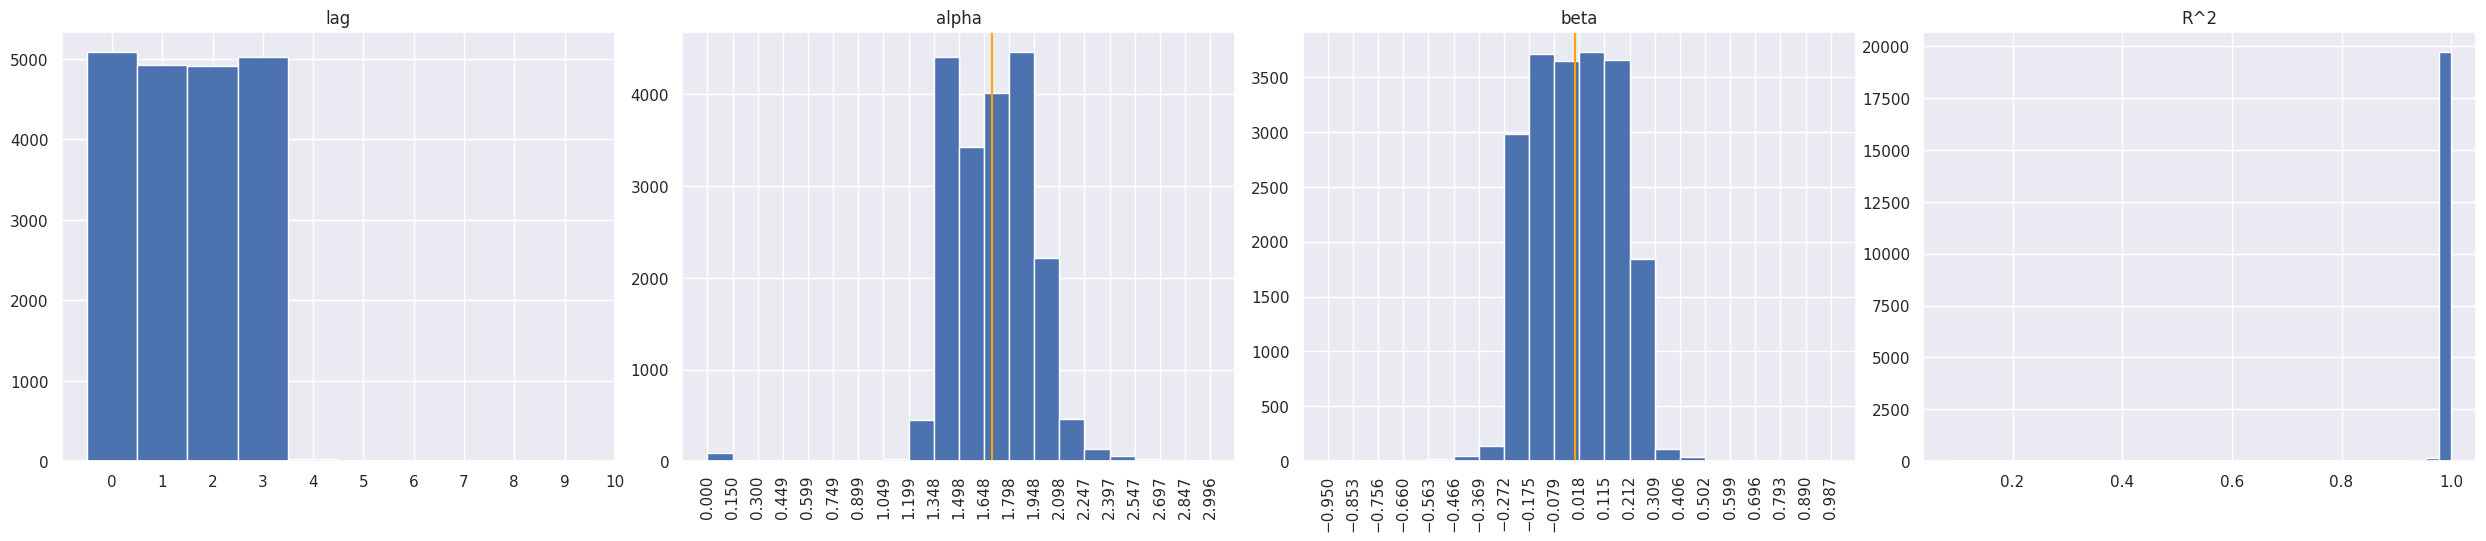

In [11]:
fig, ax = plt.subplots(1, 4, figsize=(25, 5))
plt.tight_layout()

ax[0].hist(lag_vals, bins=10, range=(0, 10), align='left')
ax[0].set_xticks(range(11))
ax[0].set_title('lag')

_, bins, _ = ax[1].hist(alpha, bins=20)
ax[1].axvline(mu_alpha, color='orange')
ax[1].set_xticks(bins)
ax[1].tick_params(axis='x', labelrotation=90)
ax[1].set_title('alpha')

_, bins, _ = ax[2].hist(beta, bins=20)
ax[2].axvline(mu_beta, color='orange')
ax[2].set_xticks(bins)
ax[2].tick_params(axis='x', labelrotation=90)
ax[2].set_title('beta')

ax[3].hist(r2s, bins=40)
ax[3].set_title('R^2')
plt.show()

In [13]:
print(f'alpha: {mu_alpha}, beta: {mu_beta}')

alpha: 1.6942529739501502, beta: 0.0028692845935240664


In [15]:
np.power(0.9, np.arange(10))

array([1.        , 0.9       , 0.81      , 0.729     , 0.6561    ,
       0.59049   , 0.531441  , 0.4782969 , 0.43046721])

In [ ]:
def lateral_objective(u, alpha, beta, w_x, w_u, plan):
    x = alpha * u + beta
    cost = np.sum(w_x * (plan - x) ** 2) + np.sum(w_u * np.diff(u) ** 2)
    return cost

def gradient(u, alpha, beta, w_x, w_u, plan):
    d = 2 * alpha * w_x
    d[:-1] += 2 * w_u
    d[1:] += 2 * w_u

    A = np.diag(d) + np.diag(-2 * w_u, k=1) + np.diag(-2 * w_u, k=-1)
    b = -2 * alpha * (plan - beta) * w_x

    return A@u + b

def minimize(u, alpha, beta, w_x, w_u, plan):
    d = 2 * alpha * w_x
    d[:-1] += 2 * w_u
    d[1:] += 2 * w_u

    A = np.diag(d) + np.diag(-2 * w_u, k=1) + np.diag(-2 * w_u, k=-1)
    b = 2 * alpha * (plan - beta) * w_x

    return np.linalg.solve(A, b)

lag: 0
lag: 1
alpha: 2.0058808955755025
beta: 0.021856217263193256
R^2: 0.9997542626613468


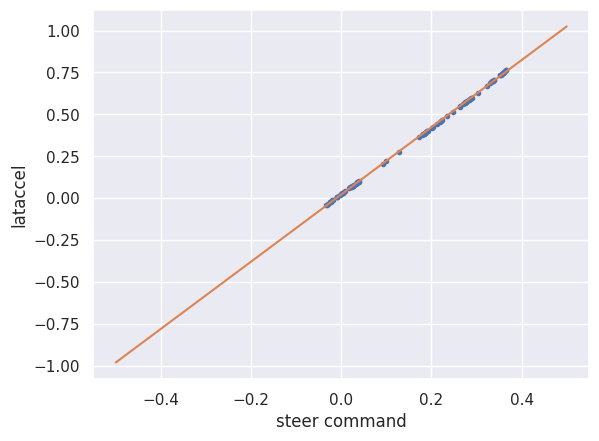

In [17]:
df = pd.read_csv('data/00000.csv')
t = df["t"].to_numpy()[:100]
vEgo = df["vEgo"].to_numpy()[:100]
aEgo = df["aEgo"].to_numpy()[:100]
roll_la = np.sin(df["roll"].to_numpy()[:100]) * ACC_G
target_la = df["targetLateralAcceleration"].to_numpy()[:100]
steerCommands = -df["steerCommand"].to_numpy()[:100]
steer_la = target_la - roll_la

length = 100
corr = signal.correlate(steer_la - steer_la.mean(), steerCommands - steerCommands.mean())
lags = signal.correlation_lags(length, length)
lag = lags[np.argmax(corr)]
print(f'lag: {lag}')

test_fit = np.array([linear_lsq(steerCommands, steer_la, x)[2] for x in range(lag, lag + 10)])
lag += np.argmax(test_fit)

print(f'lag: {lag}')

# lag=0
alpha = np.sum((steer_la[lag:] - steer_la[lag:].mean()) * (steerCommands[:100-lag] - steerCommands[:100-lag].mean())) / np.sum((steerCommands[:100-lag] - steerCommands[:100-lag].mean()) ** 2)
beta = steer_la[lag:].mean() - alpha * steerCommands[:100-lag].mean()
ssr = np.sum((alpha * steerCommands[:100-lag] + beta - steer_la[lag:])**2)
sst = np.sum((steer_la[lag:] - steer_la[lag:].mean())**2)
r2 = 1 - ssr / sst
print(f'alpha: {alpha}\nbeta: {beta}\nR^2: {r2}')

plt.plot(steerCommands[:100-lag], steer_la[lag:], '.')
x = np.linspace(-0.5, 0.5, 2)
plt.plot(x, alpha * x + beta)

plt.xlabel('steer command')
plt.ylabel('lataccel')
# plt.xlim(-2, 2)
# plt.ylim(-3, 3)
plt.show()

In [616]:
datafile = "data/GENESIS_G80_2017/00000.csv"
length = 600
df = pd.read_csv(datafile)
df = df[(df['latActive'])&(~df['steeringPressed'])]
t = df["t"].to_numpy()[:length]
vEgo = df["vEgo"].to_numpy()[:length]
aEgo = df["aEgo"].to_numpy()[:length]
roll_la = np.sin(df["roll"].to_numpy()[:length]) * ACC_G
la_steerAngle = df["latAccelSteeringAngle"].to_numpy()[:length]
la_localizer = df["latAccelLocalizer"].to_numpy()[:length]
steerCommands = df["steeringAngleDeg"].to_numpy()[:length] * np.pi / 180
target_la = la_steerAngle

### Dynamic model
$\delta_{dyn} = L\frac{a_{lat}}{V_{lon}^2} + \beta_1(a_{lat} - a_{roll}) + \beta_0$

$L$: Vehicle length

$\beta_1$: Mass times understeer gradient

$\beta_0$: Unaccounted stuff

Fit with linear least square

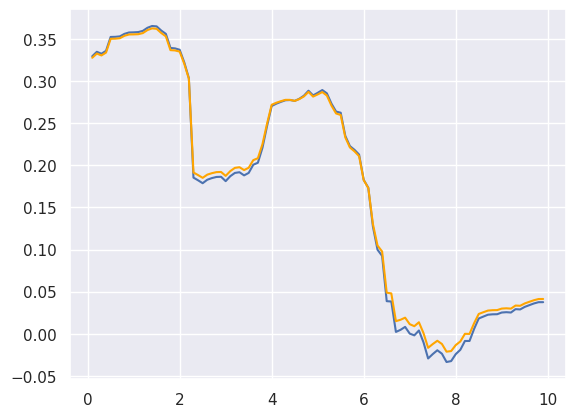

0.0034472668619882894
[ -0.42951075 -35.80329336]
1


In [20]:
length=100
corr = signal.correlate(steer_la - steer_la.mean(), steerCommands - steerCommands.mean())
lags = signal.correlation_lags(length, length)
lag = lags[np.argmax(corr)]
lag = 1

B = -steerCommands[:length-lag]
# A = np.vstack([target_la[lag:]-roll_la[lag:], vEgo[lag:]]).T
A = np.vstack([target_la[lag:] - roll_la[lag:], target_la[lag:] / vEgo[lag:] ** 2]).T
x = np.linalg.lstsq(A, B, rcond=None)[0]

steer_angle = A @ -x

fig, ax = plt.subplots(1)
ax.plot(t[lag:], steerCommands[:length-lag])
ax.plot(t[lag:], steer_angle, color='orange')
plt.show()
print(np.sum((steer_angle - steerCommands[:length-lag])**2))
print(x)
print(lag)

### Kinematic model
$a_{lat} = \beta_0 + \beta_1 * \frac{v^2 * sin(\gamma)}{L}$

steer_command $ = f_{steer}^{-1}(\delta) = arcsin(\frac{\frac{a_{lat} - \beta_0}{\beta_1}\cdot L}{v^2})$

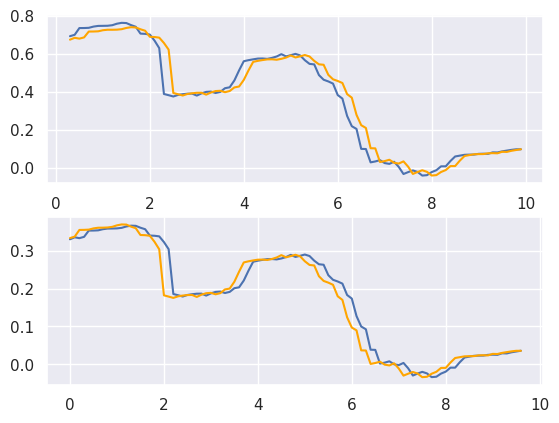

0.07577371326221764
beta0: 0.026123193367495356, beta1: 0.00175765270787338


In [24]:
L = 1
steerAngle = lambda x: x

corr = signal.correlate(steer_la - steer_la.mean(), steerCommands - steerCommands.mean())
lags = signal.correlation_lags(100, 100)
lag = lags[np.argmax(corr)]
lag = 1


pred_la = vEgo[lag:] ** 2 * np.sin(steerAngle(steerCommands[:100-lag])) / L

beta1 = np.sum((pred_la - pred_la.mean()) * (steer_la[lag:] - steer_la[lag:].mean())) / np.sum((pred_la - pred_la.mean()) ** 2)
beta0 = steer_la.mean() - beta1 * pred_la.mean()

# beta1 = 0.002257592851869056
# beta0 = -0.04918295333364523

pred_la = beta0 + beta1 * pred_la
pred_steer = (steer_la[lag:] - beta0) / beta1 / vEgo[lag:] ** 2
fig, ax = plt.subplots(2)
ax[0].plot(t[lag:], steer_la[lag:])
ax[0].plot(t[lag:], pred_la, color='orange')
ax[1].plot(t[:100-lag], steerCommands[:100-lag])
ax[1].plot(t[:100-lag], pred_steer, color='orange')
plt.show()

print(np.sum((pred_steer - steerCommands[:100-lag])**2))
print(f'beta0: {beta0}, beta1: {beta1}')

0


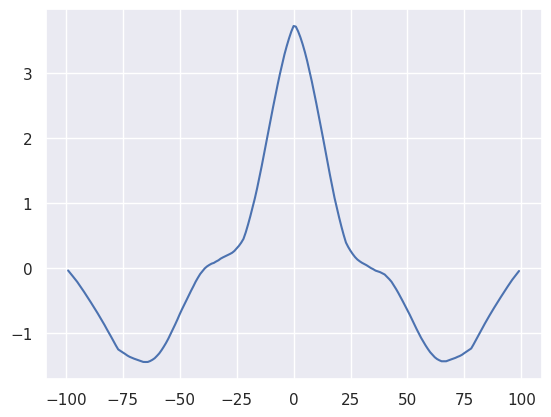

In [23]:
corr = signal.correlate(steer_la - steer_la.mean(), steerCommands - steerCommands.mean())
lags = signal.correlation_lags(100, 100)
print(lags[np.argmax(corr)])

plt.plot(lags, corr)
plt.show()

In [51]:
corr[102]

0.29559281990781294

### Check data statistics

In [ ]:
import random

beta0s = []
beta1s = []
ssq_residuals = []

numbers = random.sample(range(0, 20000), 200)
for number in numbers:
    # Load data
    datafile = f"data/{str(number).zfill(5)}.csv"
    df = pd.read_csv(datafile)
    t = df["t"].to_numpy()[:100]
    vEgo = df["vEgo"].to_numpy()[:100]
    roll_la = np.sin(df["roll"].to_numpy()[:100]) * ACC_G
    target_la = df["targetLateralAcceleration"].to_numpy()[:100]
    steerCommands = -df["steerCommand"].to_numpy()[:100]
    steer_la = target_la - roll_la

    # Fit model
    pred_la = vEgo ** 2 * np.sin(steerCommands)

    beta1 = np.sum((pred_la - pred_la.mean()) * (steer_la - steer_la.mean())) / (np.sum((pred_la - pred_la.mean()) ** 2) + 1e-8)
    beta0 = steer_la.mean() - beta1 * pred_la.mean()

    pred_la = pred_la * beta1 + beta0
    
    beta0s.append(beta0)
    beta1s.append(beta1)
    ssq_residuals.append(np.sum((pred_la - steer_la)**2))

beta0s = np.array(beta0s)
beta1s = np.array(beta1s)
ssq_residuals = np.array(ssq_residuals)

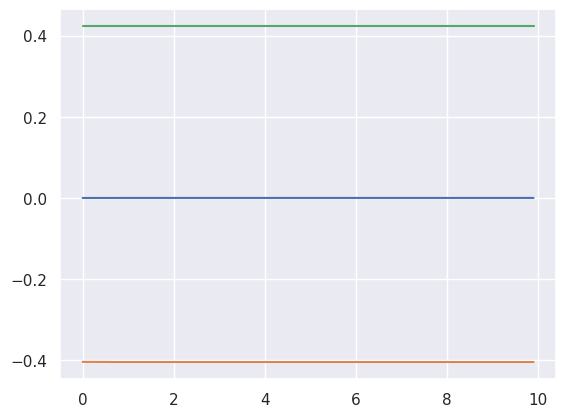

In [79]:
plt.plot(t, target_la)
plt.plot(t, steerCommands)
plt.plot(t, roll_la)

plt.show()